<a href="https://colab.research.google.com/github/kapeeshvarma/Appliances-Energy-Prediction/blob/main/Appliances_Energy_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**APPLIANCES ENERGY PREDICTION**

In this time of global uncertainty world needs energy and in increasing quantities to support economic and social progress and build a better quality of life, in particular in developing countries. But even today there are many regions which face constant power outages. These outages are primarily caused due to excess load consumed by home appliances.

Hence, the ability to predict energy consumption can not only save money for end user but can also help in generating money by giving excess energy back to Grid (in case of solar panels usage). In this project, we perform regression analysis in order to predict Appliance energy usage based on data collected from various sensors.

## Importing Data and Modules

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [165]:
# Import the necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [149]:
# Read in the dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Appliances Energy Prediction - Kapeesh Varma/data_application_energy.csv')

In [150]:
# Print Summary of the DataFrame
data.info()

# Examine a random sample from the DataFrame
data.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19735 entries, 0 to 19734
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         19735 non-null  object 
 1   Appliances   19735 non-null  int64  
 2   lights       19735 non-null  int64  
 3   T1           19735 non-null  float64
 4   RH_1         19735 non-null  float64
 5   T2           19735 non-null  float64
 6   RH_2         19735 non-null  float64
 7   T3           19735 non-null  float64
 8   RH_3         19735 non-null  float64
 9   T4           19735 non-null  float64
 10  RH_4         19735 non-null  float64
 11  T5           19735 non-null  float64
 12  RH_5         19735 non-null  float64
 13  T6           19735 non-null  float64
 14  RH_6         19735 non-null  float64
 15  T7           19735 non-null  float64
 16  RH_7         19735 non-null  float64
 17  T8           19735 non-null  float64
 18  RH_8         19735 non-null  float64
 19  T9  

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,23.20,52.400000,24.796667,1.0,24.500000,44.500000,24.7000,50.07400,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,23.23,52.326667,24.196667,1.0,24.557143,44.414286,24.7000,49.79000,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,23.23,52.266667,23.626667,1.0,24.540000,44.400000,24.7000,49.66000,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,23.20,52.200000,22.433333,1.0,24.500000,44.295714,24.6625,49.51875,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,23.20,52.200000,21.026667,1.0,24.500000,44.054000,24.7360,49.73600,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


## Exploratory Data Analysis & Visualizations

In [151]:
# Look out for Duplicated and Null Values
d2 = data.duplicated()
print(d2.value_counts())

data.isna().sum()

False    19735
dtype: int64


date           0
Appliances     0
lights         0
T1             0
RH_1           0
T2             0
RH_2           0
T3             0
RH_3           0
T4             0
RH_4           0
T5             0
RH_5           0
T6             0
RH_6           0
T7             0
RH_7           0
T8             0
RH_8           0
T9             0
RH_9           0
T_out          0
Press_mm_hg    0
RH_out         0
Windspeed      0
Visibility     0
Tdewpoint      0
rv1            0
rv2            0
dtype: int64

We can observe that none of the columns have null-values or duplicates. This is good for Data Analysis!

In [152]:
# Explore Descriptive Statistics
data.describe()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
mean,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.411665,755.522602,79.750418,4.039752,38.330834,3.760707,24.988033,24.988033
std,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.317409,7.399441,14.901088,2.451221,11.794719,4.194648,14.496634,14.496634
min,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.666667,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.916667,756.100000,83.666667,3.666667,40.000000,3.433333,24.897653,24.897653
75%,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.408333,760.933333,91.666667,5.500000,40.000000,6.566667,37.583769,37.583769
max,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530


In [153]:
# Drop unwanted columns
data.drop(columns=['lights'],inplace=True)

In [154]:
# Add 'Hours' column from 'date' column
data['hours']=(data['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)

# Add 'Weekday' column from 'date' column
data['weekday'] = pd.to_datetime(data['date']).dt.weekday

# Add log of energy consumption of appliances
data['log_appliances'] = np.log(data.Appliances)

In [155]:
# Plot the distribution of Energy Consumption
px.histogram(data, x='Appliances',marginal='box', title='Distribution of Energy Consumption of Appliances')

We can observe that the 'Appliances' column has a lot of outliers. Hence, we need to remove these outliers before performing predictions.

In [156]:
# Remove extreme 5% of the Data Outliers
data = data[data['Appliances'].between(data['Appliances'].quantile(.0), data['Appliances'].quantile(.95))]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 1.0, 'Distribution of Energy Consumption after 5% Outlier Removal')

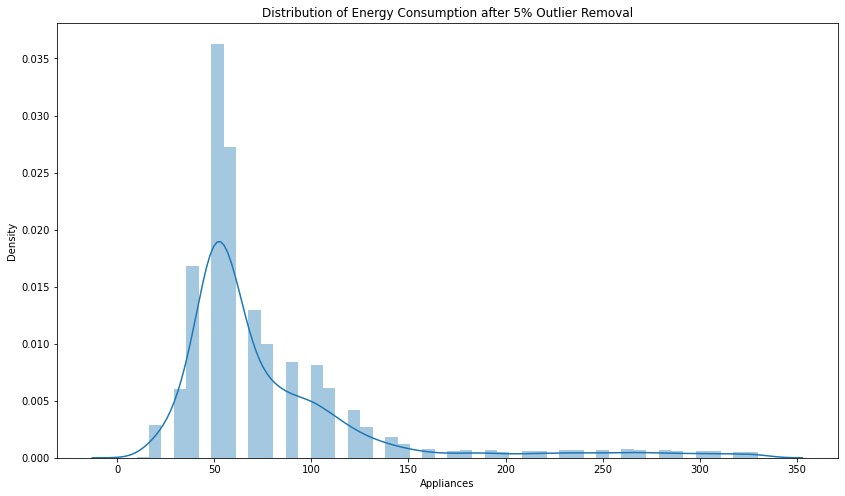

In [157]:
# Plot the distribution of Energy Consumption after 5% Outlier Removal
fig, ax = plt.subplots(sharex=True)
fig.set_size_inches(14, 8)

ax = sns.distplot(data.Appliances)
ax.set_title('Distribution of Energy Consumption after 5% Outlier Removal')

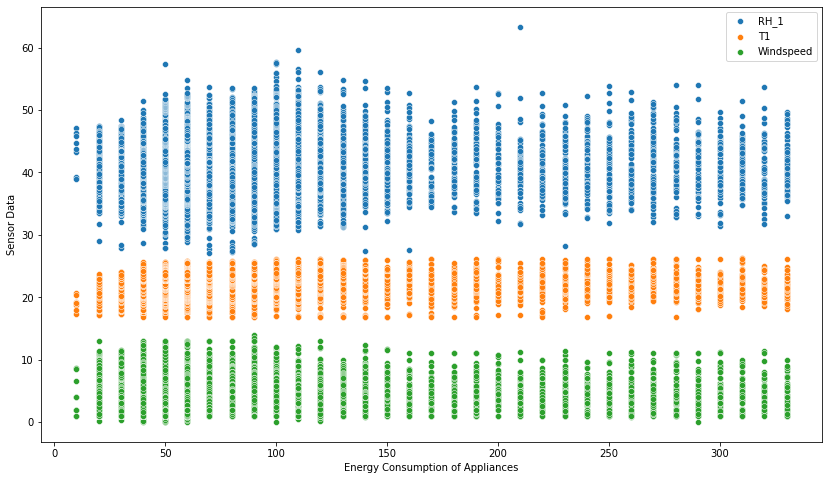

In [158]:
# Visualizing relations between some of the columns through scatter plots
fig, ax = plt.subplots(sharex=True)
fig.set_size_inches(14, 8)

ax = sns.scatterplot(x='Appliances',y='RH_1',data=data)
ax = sns.scatterplot(x='Appliances',y='T1',data=data)
ax = sns.scatterplot(x='Appliances',y='Windspeed',data=data)
ax.set_xlabel('Energy Consumption of Appliances')
ax.set_ylabel('Sensor Data')
ax.legend(['RH_1','T1','Windspeed'])

Clearly, there is no visible relation between the individual sensor data columns and the Energy consumption of Appliances.

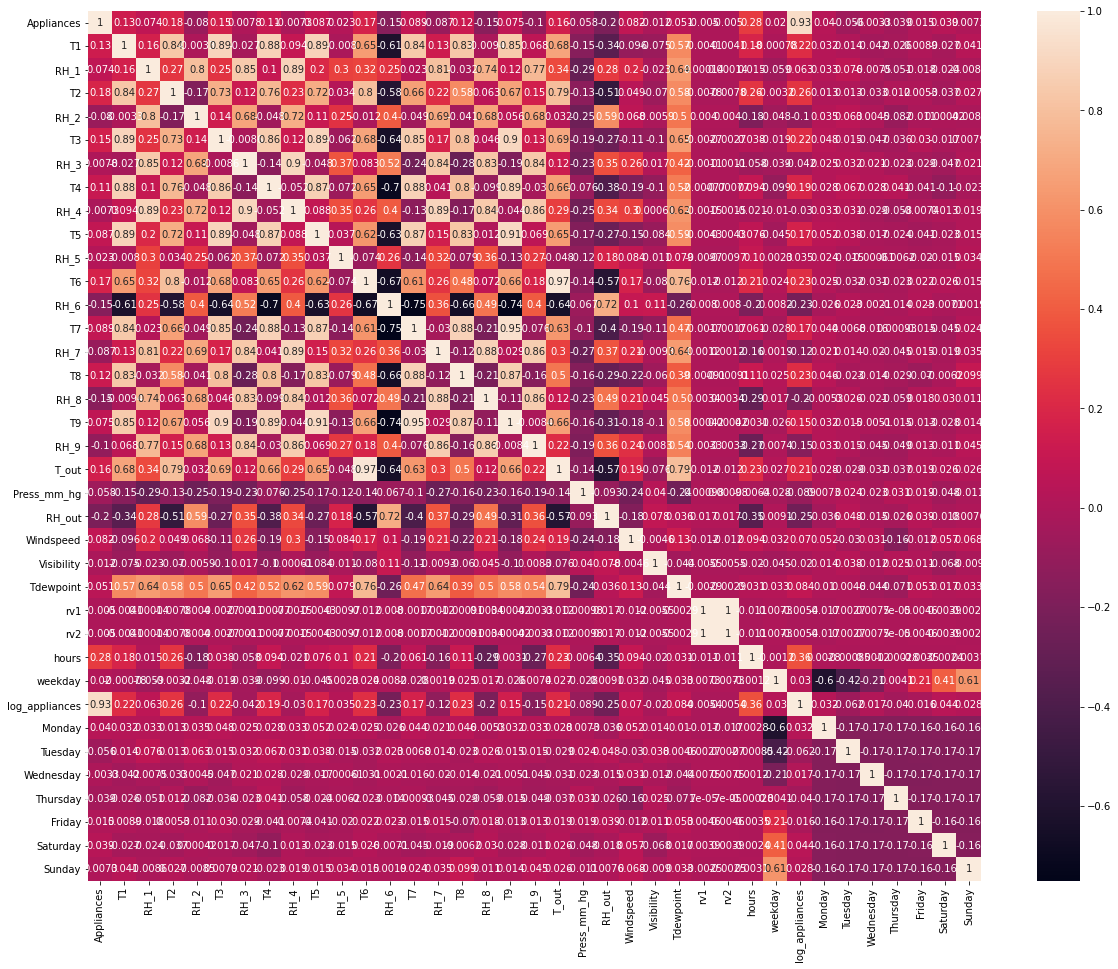

In [263]:
# Explore the Correlation between the data
fig, ax = plt.subplots()
fig.set_size_inches(20, 16)
ax = sns.heatmap(data.corr(),annot=True)

We can observe that the 'log_appliances' column is highly correlated to temperature columns i.e. 'T1', 'T2', 'T6' etc and 'hours' columns.

## Preprocessing

In [181]:
# Transform categorical variables using OneHotEncoder
enc = OneHotEncoder()
enc.fit(data[['weekday']])

one_hot = enc.transform(data[['weekday']]).toarray()
data[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']] = one_hot

data.columns

Index(['date', 'Appliances', 'T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed', 'Visibility',
       'Tdewpoint', 'rv1', 'rv2', 'hours', 'weekday', 'log_appliances',
       'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
       'Sunday'],
      dtype='object')

In [251]:
# Declare Independent and Dependent Variables i.e x and y
x = data.drop(['Appliances','date','weekday'],axis=1).values
y = data['Appliances'].values.reshape(-1,1)

In [255]:
# Split the data into Train & Test Data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

## Regression Modelling

MSE:  346.357099746442
Accuracy:  78.41305031843085


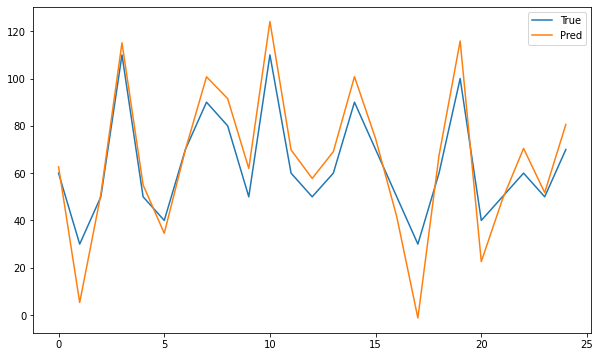

In [269]:
# Perform Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(x_train,y_train)
pred = lin_reg.predict(x_test)

# Plot True vs Predicted values for first 25 variables
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(y_test[:25])
ax.plot(pred[:25])
plt.legend(['True','Pred'])

# Compute Mean Squared Error
print('MSE: ',mean_squared_error(pred,y_test))

# Compute Accuracy
errors = abs(pred-y_test)
percent_error = 100 * np.mean(errors/y_test)
print('Accuracy: ',100-percent_error)

Best Alpha value for Ridge Regression:  {'alpha': 8}
MSE:  345.4007259050191
Accuracy:  78.53886335077681


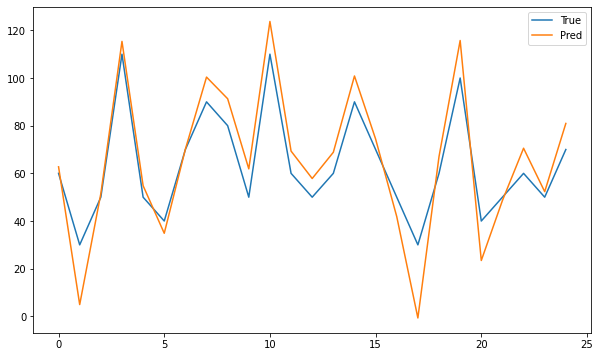

In [270]:
# Perform Ridge Regression along with Hyperparameter Tuning with GridSearchCV
ridge = Ridge()

arr = np.random.randint(0,10,size=5)
param_grid = {'alpha':arr}

ridge_cv = GridSearchCV(ridge,param_grid,cv=5)
ridge_cv.fit(x,y)
pred = ridge_cv.predict(x_test)

best = ridge_cv.best_params_
print('Best Alpha value for Ridge Regression: ',best)

# Plot True vs Predicted values for first 25 variables
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.plot(y_test[:25])
ax.plot(pred[:25])
plt.legend(['True','Pred'])

# Compute Mean Squared Error
print('MSE: ',mean_squared_error(pred,y_test))

# Compute Accuracy
errors = abs(pred-y_test)
percent_error = 100 * np.mean(errors/y_test)
print('Accuracy: ',100-percent_error)